In [1]:
"""
BIOINFORMATICS: LAB11
@author: Irene Benedetto
"""
from utils import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

Length of the transcriptome dataframe: (5000, 131)
Length of the genome dataframe: (5000, 367)
Length of the proteome dataframe: (5000, 160)


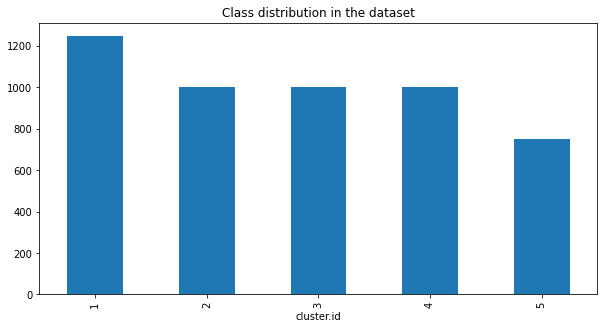

In [2]:
transcriptome_df, genome_df, proteome_df, labels_df = create_dataframe()

transcriptome_df = transcriptome_df.astype(np.float32)
genome_df = genome_df.astype(np.float32)
proteome_df = proteome_df.astype(np.float32)

plt.figure(figsize=(10, 5))
labels_df.groupby(['cluster.id']).size().plot(kind='bar', title='Class distribution in the dataset')
plt.savefig('class_distribution.png')

# Preprocessing

In [3]:
transcriptome_df

,ACACA,ACVRL1,AKT1,AKT1S1,ANXA1,AR,ARAF,ASNS,ATM,BAD,BAK1,BAP1,BAX,BCL2,BCL2L1,BCL2L11,BECN1,BID,BRAF,BRCA2,CASP7,CAV1,CCNB1,CCND1,CCNE1,CCNE2,CDH1,CDH2,CDH3,CDKN1A,CDKN1B,CHEK1,CHEK2,CLDN7,COL6A1,CTNNB1,DIRAS3,DVL3,EEF2,EEF2K,...,PTEN,PXN,RAB25,RAD50,RAD51,RAF1,RB1,RBM15,RPS6,RPS6KA1,RPS6KB1,SERPINE1,SFRS1,SHC1,SMAD1,SMAD3,SMAD4,SQSTM1,SRC,STAT3,STAT5A,STK11,STMN1,SYK,TGM2,TP53,TP53BP1,TSC1,TSC2,TUBA1B,VHL,WWTR1,XBP1,XRCC1,XRCC5,YAP1,YBX1,YWHAB,YWHAE,YWHAZ
subject1,-0.382628,0.773859,1.235067,0.311837,-1.322433,0.125027,1.135766,0.887652,0.434295,0.792249,0.816072,0.892515,0.997436,-0.722008,-0.546062,0.608405,1.657646,-0.260651,0.824460,0.157917,-0.509422,1.159025,-1.302120,-0.103664,1.099699,2.512761,0.441461,1.241120,1.001900,-0.033458,0.041625,2.057841,1.235023,1.315586,-0.360098,-0.496278,-1.262362,-0.744727,-1.055508,-1.140374,...,0.170565,-0.600422,-0.515013,-0.006318,0.387784,-1.331684,-0.999112,-0.649975,-0.703950,-1.647632,1.093578,0.740213,1.207905,0.724518,2.093153,1.432584,-0.454698,-0.299077,0.547195,0.456249,1.328692,0.233496,1.328945,-1.588586,0.799328,0.477056,-0.745882,0.042014,-0.668435,-0.237119,0.545911,1.765570,0.140558,2.316117,-1.079324,1.038684,0.308403,0.041102,1.138597,0.236691
subject2,1.034323,-1.277797,-1.381578,-0.907082,0.165761,-0.738485,1.060104,-0.396611,-0.573676,0.346631,-0.784320,-1.378031,0.587226,-1.079917,-0.861091,0.277998,-0.437616,0.466483,0.962232,-0.852136,2.202742,0.106181,-0.177723,-0.149387,0.474804,0.239183,-0.874721,0.752076,0.438080,-0.276326,-0.449148,0.428045,0.743514,-0.419543,-0.162349,1.425943,0.239003,1.543720,-0.787814,-0.761421,...,-1.565747,-0.274879,-0.368151,-2.449671,-0.479110,0.641461,0.048775,1.124373,-1.032388,-1.284588,0.618500,-0.582270,-1.482028,-0.869513,-0.661979,-0.358499,0.181274,0.230029,1.586883,0.397146,-0.796955,0.155780,-0.309888,-0.086642,-0.455943,0.799975,1.229677,-0.826374,-0.991603,-0.536898,1.038076,0.250861,0.659198,-0.324783,-0.927847,0.964626,0.837063,-0.133645,0.214688,-0.922170
subject3,-1.004588,0.789062,0.567978,-0.527300,1.390555,0.769299,-1.356954,0.088091,1.128646,0.638124,0.601730,0.304434,-1.611783,2.553671,0.713413,1.110176,-0.328087,0.061010,0.592590,0.994146,-0.014666,-0.171496,0.629674,0.473055,0.420157,-0.416206,2.257766,0.370079,0.111945,0.863213,2.752920,-0.843650,0.433851,-0.736582,0.810741,1.935537,0.508535,0.756472,1.446797,1.497587,...,0.868236,-0.312698,-0.727977,0.815378,1.879122,1.036950,-0.130412,0.622645,-0.608441,0.840225,-0.517085,1.323246,-1.028751,0.679464,-0.959821,-0.207958,1.206383,1.310142,-0.892488,0.727886,1.481707,0.409376,-0.007076,-0.311909,0.137748,-1.542824,0.520814,-0.312157,-0.965046,1.684507,-0.365328,0.509085,0.070680,-0.352452,0.991059,-1.825277,-1.643199,1.010785,-1.621143,1.239699
subject4,1.593204,-0.944045,-1.308022,-0.354564,0.730496,-0.883797,0.848080,0.499729,-1.786113,0.366046,-0.425595,-1.726852,1.059294,1.114653,-0.513735,-0.198966,-0.400469,0.574404,0.618519,-0.424346,1.590846,1.007831,0.771176,0.101027,0.603483,1.004252,-0.729347,-0.809035,1.239051,1.997591,-0.313880,0.904801,0.386711,-0.490479,0.725690,0.778683,0.733768,0.310681,-1.411233,-1.029696,...,-0.843442,-0.379919,1.059808,-2.224085,-0.565384,1.211410,-1.311786,0.750972,-0.912696,-0.885283,1.537578,-0.025082,-1.136157,-0.939156,-0.049680,0.966150,-0.606708,-0.051394,2.235091,0.128931,-0.773450,0.592272,0.646964,0.565497,-0.217898,-0.090529,1.367392,-0.636792,-0.557447,-0.080791,0.246307,0.267167,-0.650298,0.806887,-1.110888,-0.182302,-1.713608,-1.256615,0.277525,-0.913025
subject5,0.925223,-1.099246,-0.470729,0.209433,-0.622930,-0.681101,1.354921,0.497857,-0.746768,0.057257,-0.157442,-0.824122,0.687150,-1.145007,-0.571509,0.129506,-0.873336,1.023468,0.703330,-1.297106,1.630856,0.073098,0.350000,0.050915,-0.680510,1.729585,-0.443241,1.090397,0.965723,-0.462191,-0.520527,1.938178,1.015503,-0.476072,-0.997830,0.883569,-2.236780,1.055173,-0.377743,-0.760424,...,-1.443059,-0.529264,-0.890934,-1.570077,0.216231,0.276864,-1.423561,

## Normalization

In [4]:
def normalize(dataset):
    mean = dataset.mean()
    std = dataset.std()
    return (dataset - mean) / (std + 10**(-11))
    

In [5]:
transcriptome_df = normalize(transcriptome_df)
genome_df = normalize(genome_df)
proteome_df = normalize(proteome_df)

## Outlier removal

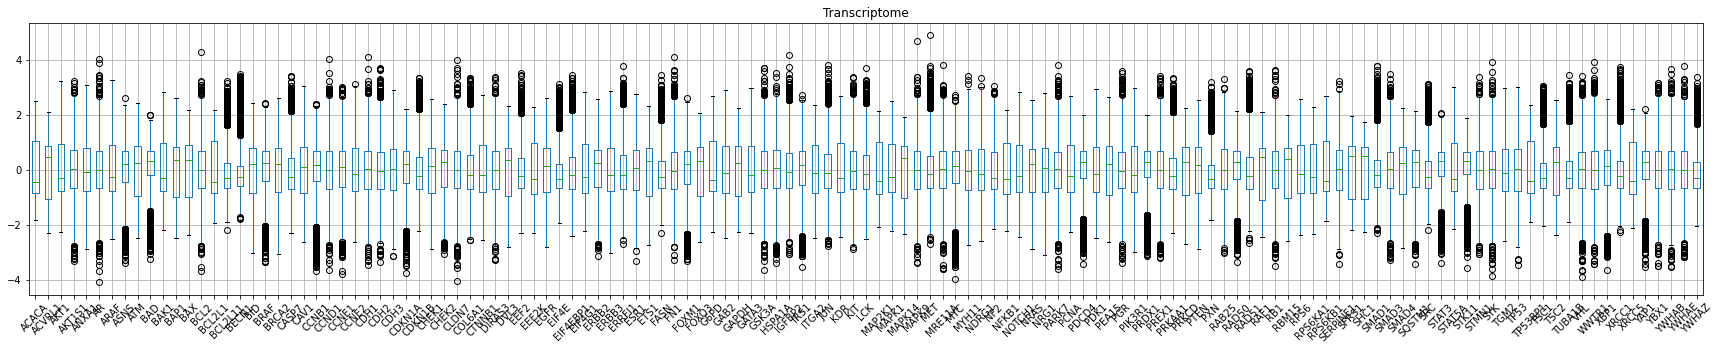

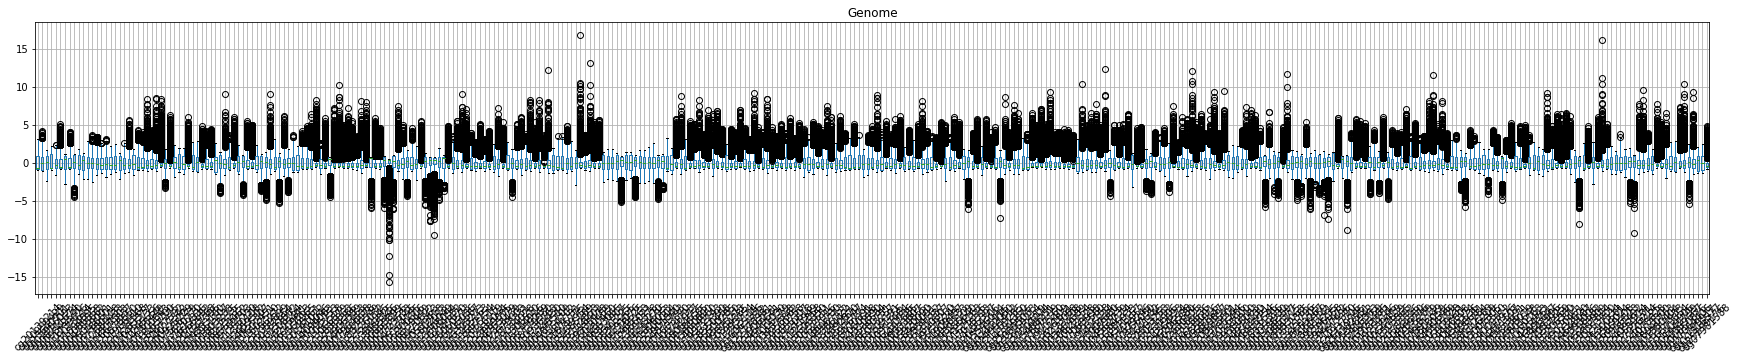

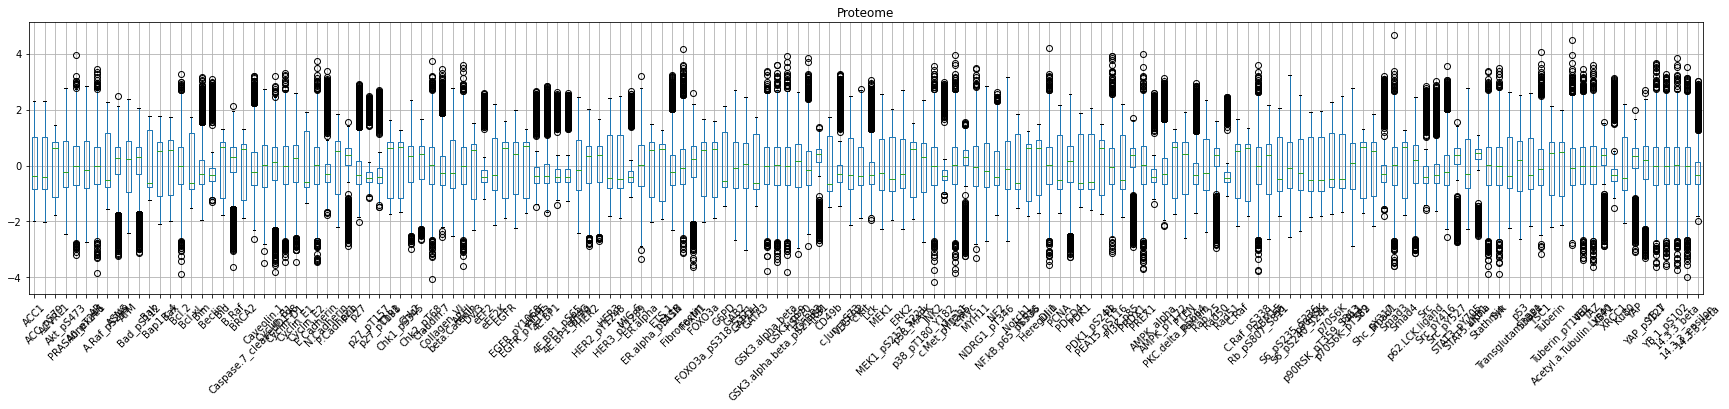

In [6]:
# boxplot for outlier detection
for dataset, name in zip([transcriptome_df, genome_df, proteome_df], ['Transcriptome', 'Genome', 'Proteome']):
    plt.figure(figsize=(30, 5))
    n_cols = len(dataset.columns.values)/2
    fig = dataset.boxplot(rot=45)
    fig.set_title(name)
    plt.show()

In [7]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

clf = LocalOutlierFactor()
transcriptome_outliers = clf.fit_predict(transcriptome_df)
genome_outliers = clf.fit_predict(genome_df)
proteome_outliers = clf.fit_predict(proteome_df)
print(f'Number of outliers detected with LOF: ({len(np.where(transcriptome_outliers == -1)[0])},{len(np.where(genome_outliers == -1)[0])},{len(np.where(proteome_outliers == -1)[0])})')

clf = IsolationForest(max_samples=450)
transcriptome_outliers = clf.fit_predict(transcriptome_df)
genome_outliers = clf.fit_predict(genome_df)
proteome_outliers = clf.fit_predict(proteome_df)
print(f'Number of outliers detected with Isolation Forest: ({len(np.where(transcriptome_outliers == -1)[0])},{len(np.where(genome_outliers == -1)[0])},{len(np.where(proteome_outliers == -1)[0])})')

clf = OneClassSVM(nu=0.1) # too sensitive to noise
transcriptome_outliers = clf.fit_predict(transcriptome_df)
genome_outliers = clf.fit_predict(genome_df)
proteome_outliers = clf.fit_predict(proteome_df)
print(f'Number of outliers detected with One Class SVM: ({len(np.where(transcriptome_outliers == -1)[0])},{len(np.where(genome_outliers == -1)[0])},{len(np.where(proteome_outliers == -1)[0])})')

Number of outliers detected with LOF: (0,4,0)
Number of outliers detected with Isolation Forest: (14,495,69)
Number of outliers detected with One Class SVM: (502,501,499)


## Missing-data imputation

In [8]:
print('Number of missing values')
n_nan_transcriptome = len(np.where(transcriptome_df == np.nan)[0])
n_nan_genome = len(np.where(genome_df == np.nan)[0])
n_nan_proteome = len(np.where(proteome_df == np.nan)[0])
print(f' - In the transcriptome df: {n_nan_transcriptome} ')
print(f' - In the genome df: {n_nan_genome} ')
print(f' - In the proteome df: {n_nan_proteome} ')

Number of missing values
 - In the transcriptome df: 0 
 - In the genome df: 0 
 - In the proteome df: 0 


# Similarity network fusion

In [9]:
def similarity_matrix_withforloops(dataset,n_neighbors=1, mu=0.5):
    """ a copy of the previous similarity_matrix() """
    W_tilda = euclidean_distances(dataset)
    epsilon = np.zeros(W_tilda.shape)
    W = np.zeros(W_tilda.shape)
    for i in range(W_tilda.shape[0]):
        N_i = np.mean(np.sort(W_tilda[i, :])[1:n_neighbors+1])

        for j in range(W_tilda.shape[1]):
            N_j = np.mean(np.sort(W_tilda[:, j])[1:n_neighbors+1])
            epsilon[i, j] = (N_i + N_j + W_tilda[i, j])/3
            W[i, j] = np.exp(- W_tilda[i, j]**2 / (epsilon[i, j]*mu))

    return W

In [10]:
from sklearn.metrics.pairwise import euclidean_distances

def similarity_matrix(dataset,n_neighbors=1, mu=0.8):
    W_tilda = euclidean_distances(dataset)
    # it is a row matrix in which any value is the mean distance of i and its nn
    mean_distance = np.mean(np.sort(W_tilda)[:, 1:n_neighbors+1], axis=1)
    # matrix of distances between i and its neighbors
    mean_distance_nn_i = np.repeat(np.expand_dims(mean_distance, -1), W_tilda.shape[1], axis=1)
    # matrix of distances between j and its neighbors
    mean_distance_nn_j = np.repeat(np.expand_dims(mean_distance, 0), W_tilda.shape[0], axis=0)
    
    epsilon = (mean_distance_nn_i + mean_distance_nn_j + W_tilda) / 3
    W = np.exp( - (euclidean_distances(dataset)**2) / (mu*epsilon))
    return W

def status_matrix(W):
    # compute the denominator
    # np.sum(W, axis=1) is a column with the k == i value
    # W.diagonal() is a column
    W_ik = np.expand_dims(np.sum(W, axis=1) - W.diagonal(),-1)
    # for broadcasting
    W_ik = np.repeat(W_ik, W.shape[1], axis=1)
    
    P = W / (2*W_ik + 10**(-8))
    np.fill_diagonal(P, 0.5)
    return P


def kernel_matrix(W, n_neighbors=1):
    S = np.zeros(W.shape)
    index_n_neighbors = np.argsort(-W)[:, 1:n_neighbors+1]
    # the function insert in each row of S the value 1 in the row indeces specified
    # in the vecor index_n_neighbors
    np.put_along_axis(S, index_n_neighbors, 1, axis=1)
    
    # extract the total distance between i and its neighbors
    W_N = np.sum(-np.sort(-W)[:, 1:n_neighbors+1], axis=1)
    temp = np.divide(W, (np.repeat(np.expand_dims(W_N, -1), W.shape[1], axis=1) + 10**(-8)) )
    return np.multiply(S, temp)


## Status and Kernel matrices

In [11]:
n_neighbors = 300

W = []
P = []
S = []

for dataset in [transcriptome_df, genome_df, proteome_df]:
    w = similarity_matrix(dataset.values, n_neighbors)
    p = status_matrix(w)
    s = kernel_matrix(w, n_neighbors)
    W.append(w)
    P.append(p)
    S.append(s)       

## The network fusion process

In [12]:
# start the network fusion process
# update only the status matrix, while the kernel matrix does not change
T = 12
omics = [transcriptome_df, genome_df, proteome_df]
m = len(omics)

for t in range(T):
    for i, dataset in enumerate(omics):
        # update the status matrix 
        p_t = np.zeros(P[0].shape)
        for p in [p for j, p in enumerate(P) if not j==i]:
            p_t  += p

        p_t = p_t / (m-1)
        P[i] = S[i] * p_t * (S[i]**T)


P_c = (P[0] + P[1] + P[2])/m

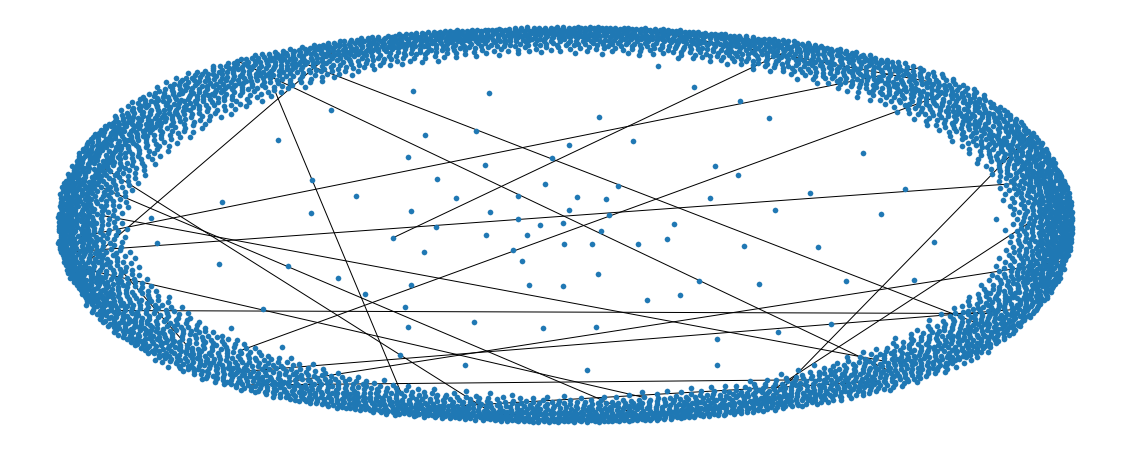

In [13]:
import networkx as nx
ax, fig = plt.subplots(figsize=(20, 8))
G = nx.Graph(P_c, ax=ax)
nx.draw(G, node_size=30, linewidths=0.1) # ??

In [20]:
P_c

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])